In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau


print(tf.__version__)


2.17.1


In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:50<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
img_size = (150, 150)
batch_size = 32

# Create train, test, and validation datasets
train_dataset = image_dataset_from_directory(
    os.path.join(path, 'chest_xray', 'train'),
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    color_mode='grayscale'
)

test_dataset = image_dataset_from_directory(
    os.path.join(path, 'chest_xray', 'test'),
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale'
)

val_dataset = image_dataset_from_directory(
    os.path.join(path, 'chest_xray', 'val'),
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale'
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [4]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

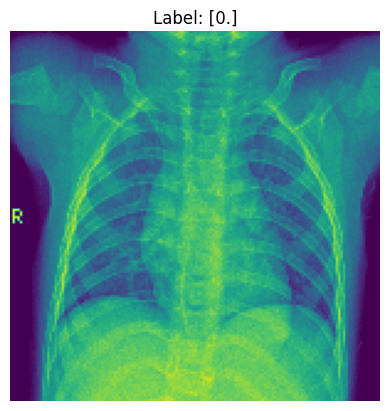

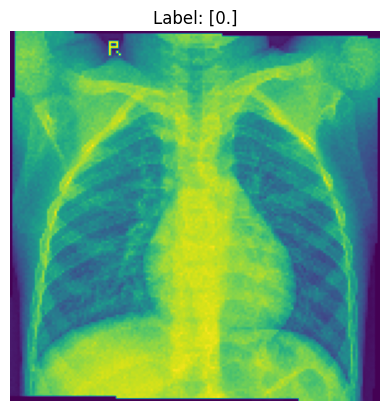

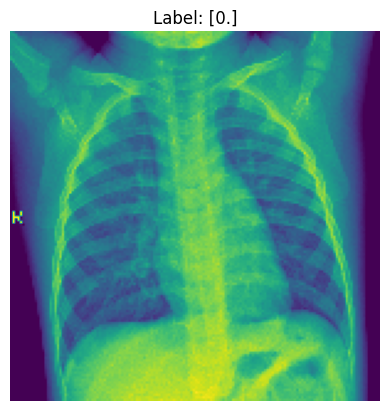

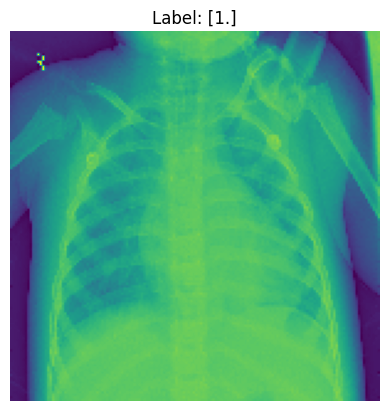

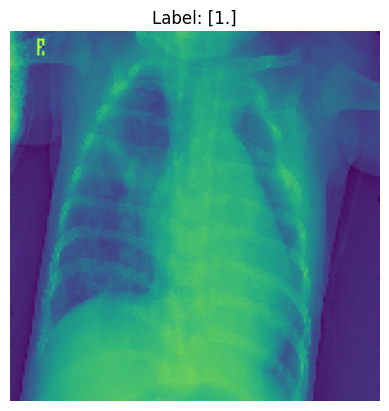

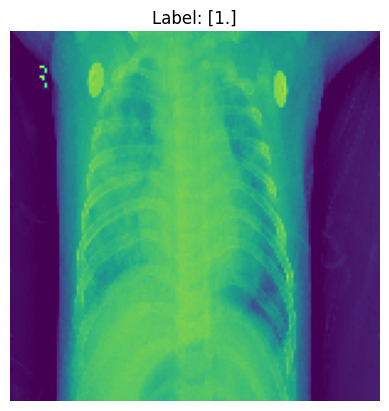

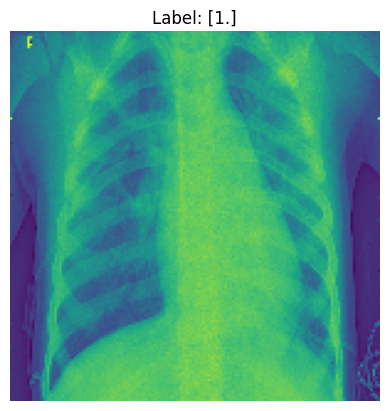

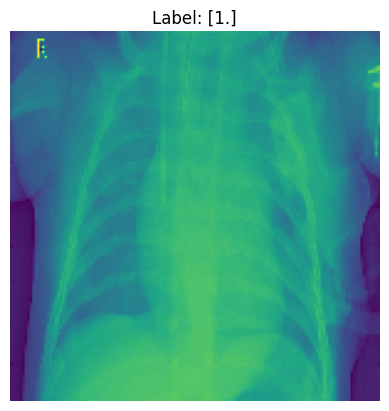

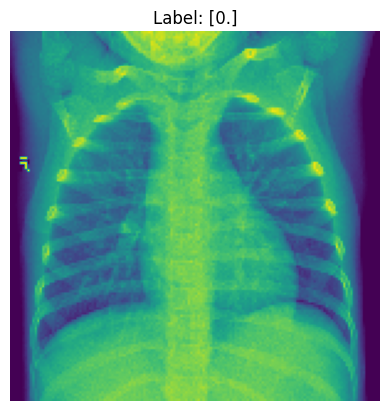

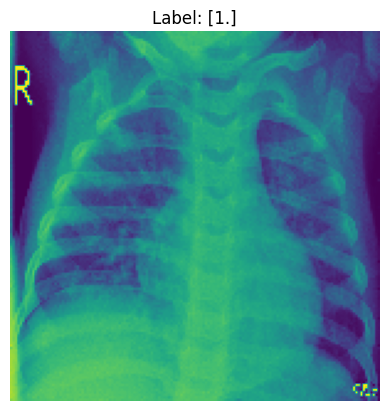

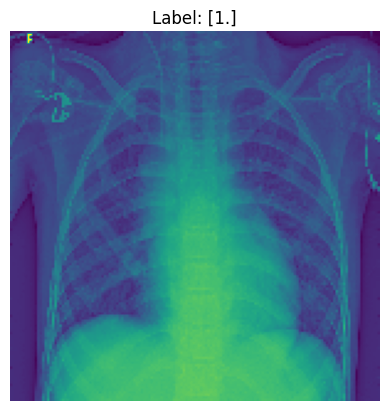

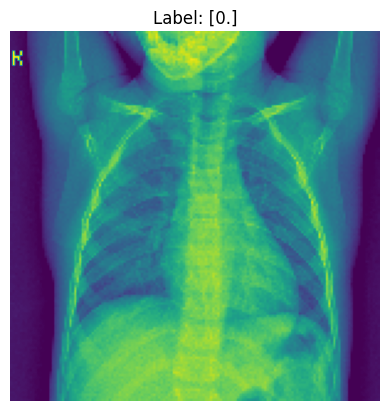

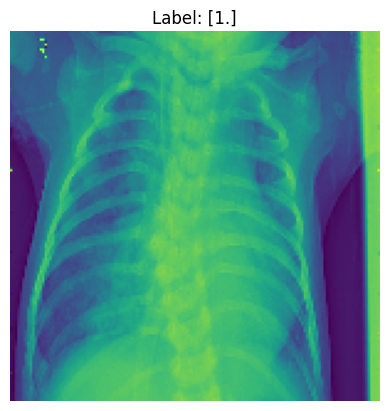

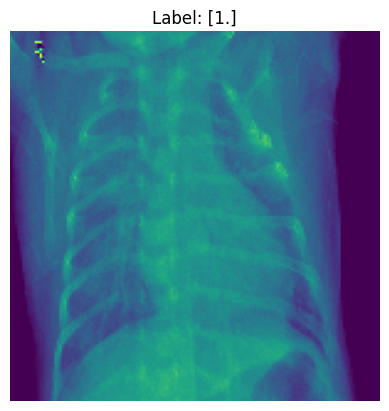

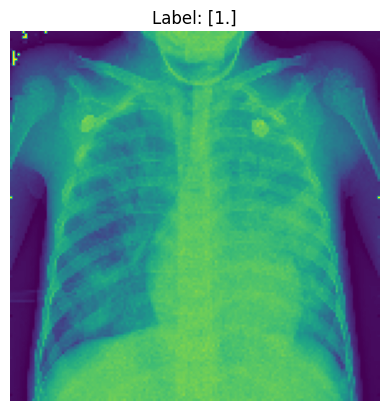

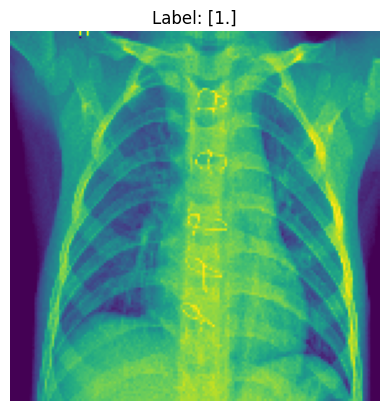

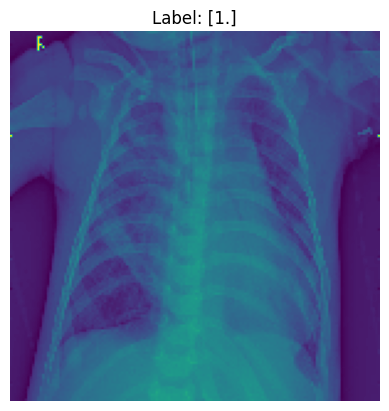

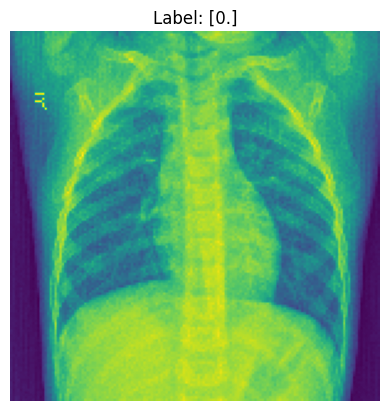

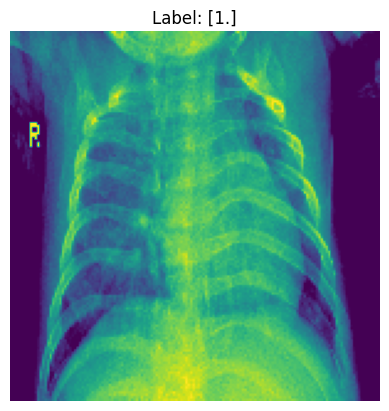

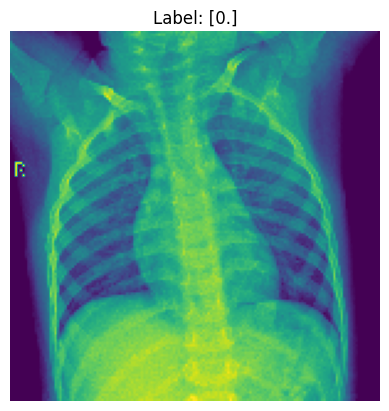

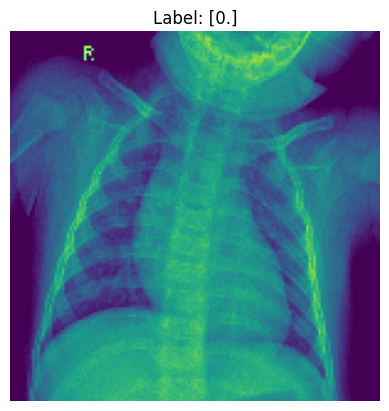

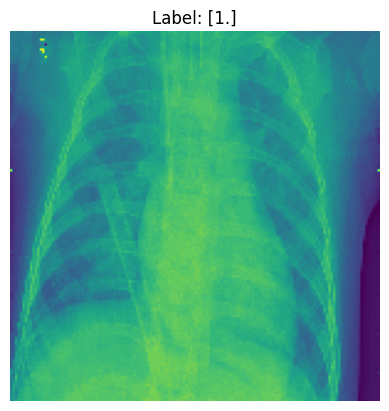

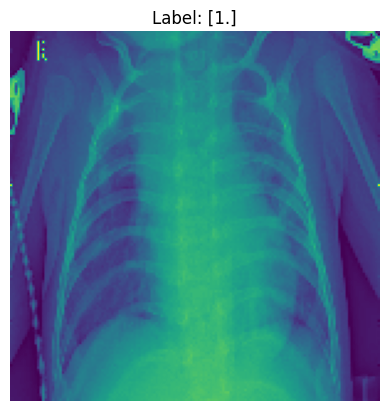

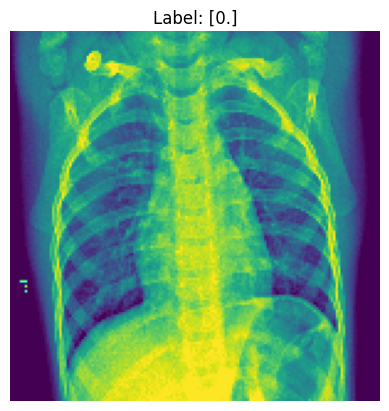

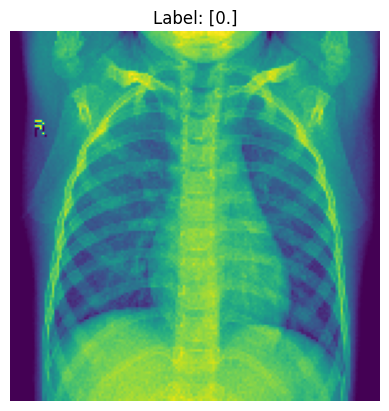

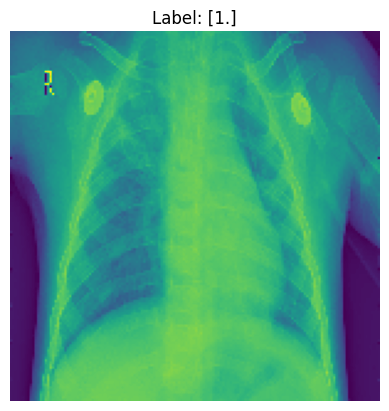

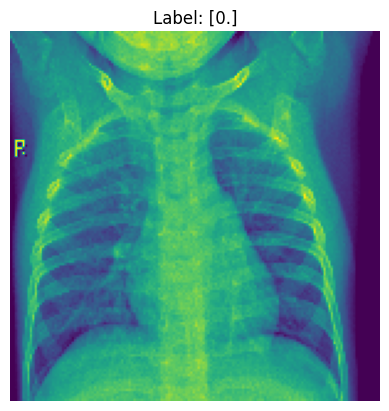

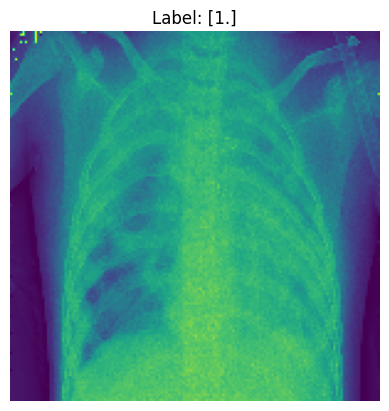

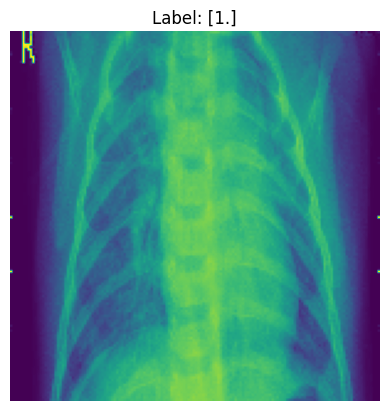

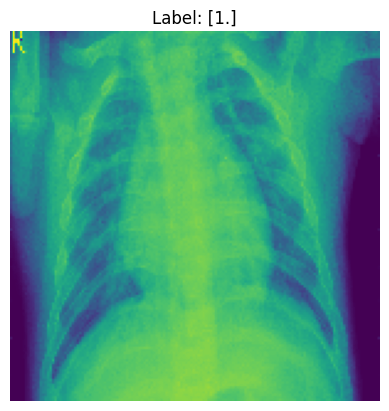

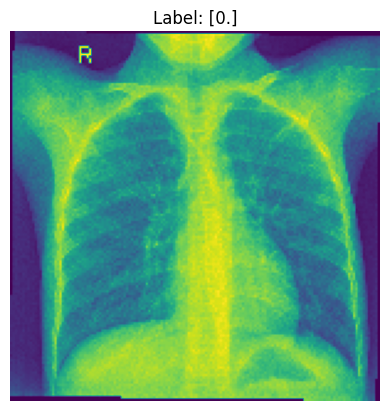

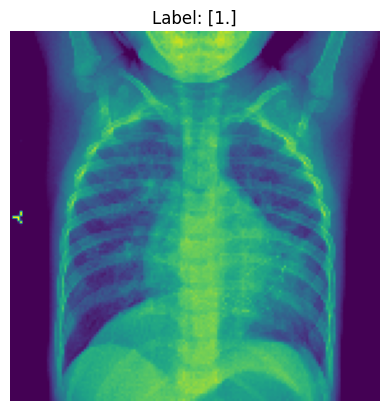

In [5]:
for images, labels in train_dataset.take(1):  # Take one batch
       for i in range(images.shape[0]):  # Iterate through images in the batch
           image = images[i].numpy()

           plt.imshow(image, cmap="gray" if image.ndim == 2 else None)
           plt.title(f"Label: {labels[i].numpy()}")
           plt.axis('off')
           plt.show()

In [6]:
train_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomBrightness(factor=0.2),  # Random brightness adjustment
    tf.keras.layers.RandomContrast(factor=0.2),    # Random contrast adjustment
    #tf.keras.layers.Rescaling(offset=-1, scale=2), # Normalize (equivalent to mean=0.5, std=0.5)
])

In [7]:
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_aug_dataset = train_dataset.map(lambda x, y: (train_augmentation(x), y))
normal_ds = train_aug_dataset.unbatch().filter(lambda x, y:  tf.equal(y[0], 0.) ).batch(32)
train_dataset = train_dataset.concatenate(train_aug_dataset)

In [17]:
model = Sequential()


# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), padding = "same"))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected (dense) layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))  # Dropout to reduce overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))  # Reduced dropout

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))  # Single neuron for binary classification

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 73, 73, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,634,305 (13.86 MB)

 Trainable params: 3,633,345 (13.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
model.fit(train_dataset, epochs=30, batch_size=32, validation_data=val_dataset,
          callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9085 - loss: 0.3822 - val_accuracy: 0.8750 - val_loss: 0.2064 - learning_rate: 0.0010
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9657 - loss: 0.1026 - val_accuracy: 0.8750 - val_loss: 0.1481 - learning_rate: 0.0010
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9798 - loss: 0.0567 - val_accuracy: 0.6250 - val_loss: 4.0225 - learning_rate: 0.0010
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9858 - loss: 0.0431 - val_accuracy: 0.8750 - val_loss: 0.1265 - learning_rate: 0.0010
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9876 - loss: 0.0344 - val_accuracy: 0.9375 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9890 - loss: 0.0319
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9890 - loss: 0.

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6855 - loss: 3.2604
Loss: 1.7964082956314087
Accuracy: 0.8092948794364929


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.53      0.67       234
         1.0       0.77      0.98      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624



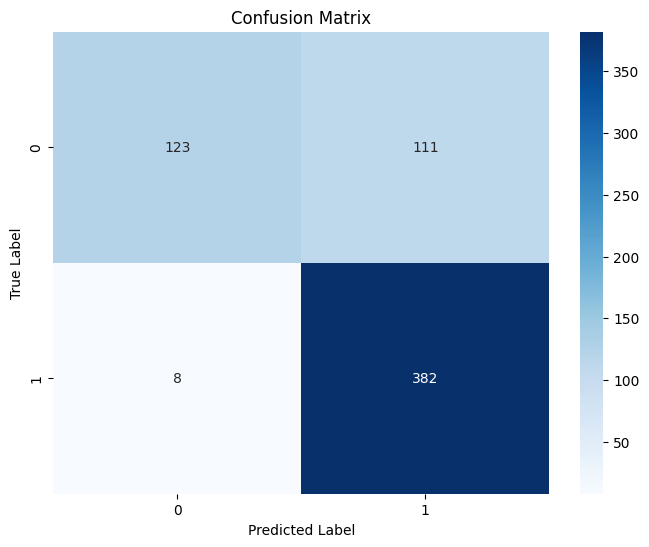

In [22]:
y_pred_prob = model.predict(test_dataset)  # Predicted probabilities

# Apply a custom threshold
threshold = 0.4  # Custom threshold
y_pred_classes = (y_pred_prob > threshold).astype(int).flatten()  # Convert probabilities to binary classes

# Extract true labels from the test data
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))  # Removed target_names for now

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")  # Removed xticklabels and yticklabels for now
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()